Import packages

In [1]:
import csv
import pickle
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.utils import np_utils
from keras.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import io
from sklearn import model_selection

Set constants

In [2]:
input_dt = 10
output_dt = 2
timepoints = 250
reach_start = 30

bins_before = 10
bins_current = 0
bins_after = 0

Load data

In [3]:
M1_rates = np.array(io.loadmat('./Documents/decoder/data/EN10_d1_imec0_M1_rates.mat')['rates']) # n x t x k
M1_rates = np.swapaxes(M1_rates,0,2) # k x t x n
behavioral_data = np.load('./Documents/decoder/code/EN10_d1_behavioral.npy',allow_pickle=True)

Data Preprocessing: 
1. Trim the neural data to match the lengths of the behavioral data since they have different lengths
2. Downsample the behavioral_data to match the temporal resolution of the neural data
3. bin the firing rates
4. split into training and testing sets
5. reshape sets
6. Z-score X and zero center y

In [4]:
# trim the firing rates to match behavioral data
trimmed_rates = []
for i in range(len(M1_rates)):
    if behavioral_data[i]:
        trimmed_rate = M1_rates[i][int(reach_start-bins_before):int(reach_start+(timepoints//(input_dt/output_dt))),:].tolist()
        trimmed_rates.append(trimmed_rate)

# remove reaches with not enough timepoints
behavioral_data = [reach for reach in behavioral_data if reach]

# downsample behavioral_data to match temporal resolution of neural data
downsampled_behav_data = []
for reach in behavioral_data:
    new_reach = []
    # take average of every 5 time points
    for i in range(0, len(reach), 5):
        new_timebin = np.mean(np.array([reach[i], reach[i+1], reach[i+2], reach[i+3], reach[i+4]], dtype=float), axis=0)
        new_reach.append(new_timebin)
    downsampled_behav_data.append(new_reach)
downsampled_behav_data = np.array(downsampled_behav_data)
y_shape = downsampled_behav_data.shape

# bin firing rates
binned_data = []
num_bins = bins_before+bins_current
for example in trimmed_rates:
    new_example = []
    for i in range(num_bins, len(example)):
        new_example.append(example[i-num_bins:i])
    binned_data.append(new_example)
binned_data = np.array(binned_data, dtype=float)

# split into testing and training sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(binned_data, downsampled_behav_data, test_size=0.3, random_state=1)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
orig_y_train_shape, orig_y_test_shape = y_train.shape, y_test.shape

# reshape firing rates and behavioral data to fit lstm 
# X.shape = (#reaches*#timebins, #bins decoded, #neurons)
# y.shape = (#reaches*#timebins, #features)
X_train = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2], X_test.shape[3]))
y_train = np.reshape(y_train, (y_train.shape[0]*y_train.shape[1], y_train.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], y_test.shape[2]))

#Z-score "X" inputs. 
X_train_mean = np.nanmean(X_train, axis=0)
X_train_std = np.nanstd(X_train, axis=0)
X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_train_mean)/X_train_std

#Zero-center outputs
y_train_mean = np.mean(y_train,axis=0)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

declare, train LSTM and predict y with trained model

In [10]:
num_units = 600
num_epochs = 10
dropout = 0

model = Sequential()
model.add(LSTM(units=num_units, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(y_train.shape[1]))

model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs)

y_test_predicted = model.predict(X_test)

Epoch 1/10
129/129 [==============================] - 7s 39ms/step - loss: 5.6663 - accuracy: 0.6137
Epoch 2/10
129/129 [==============================] - 5s 37ms/step - loss: 4.0210 - accuracy: 0.6821
Epoch 3/10
129/129 [==============================] - 5s 38ms/step - loss: 3.3755 - accuracy: 0.7066
Epoch 4/10
129/129 [==============================] - 5s 38ms/step - loss: 3.2452 - accuracy: 0.7143
Epoch 5/10
129/129 [==============================] - 5s 38ms/step - loss: 2.9625 - accuracy: 0.7339
Epoch 6/10
129/129 [==============================] - 5s 38ms/step - loss: 2.7316 - accuracy: 0.7473
Epoch 7/10
129/129 [==============================] - 5s 38ms/step - loss: 2.6548 - accuracy: 0.7639
Epoch 8/10
129/129 [==============================] - 5s 38ms/step - loss: 2.2895 - accuracy: 0.7876
Epoch 9/10
129/129 [==============================] - 5s 38ms/step - loss: 2.2091 - accuracy: 0.7874
Epoch 10/10
129/129 [==============================] - 5s 39ms/step - loss: 2.0595 - accura

Plot and save results

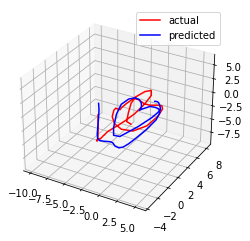

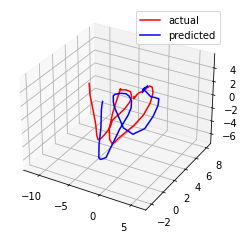

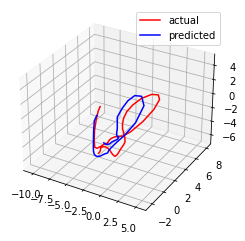

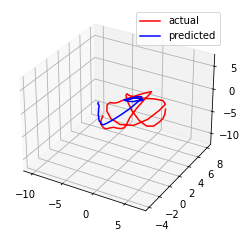

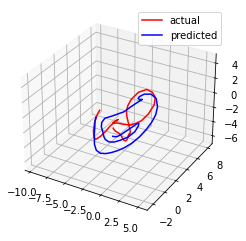

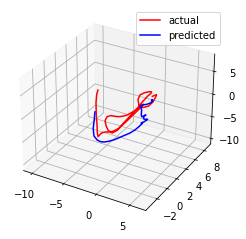

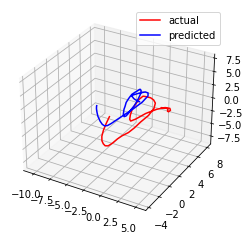

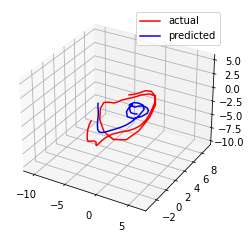

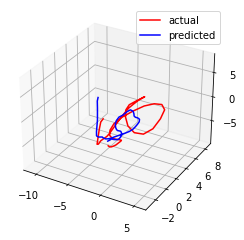

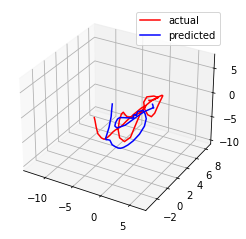

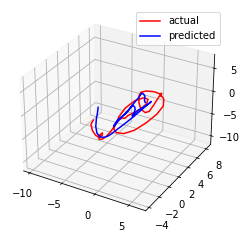

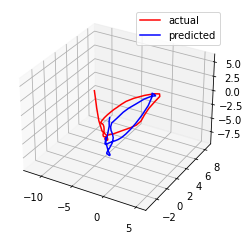

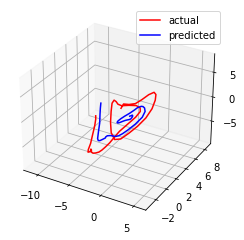

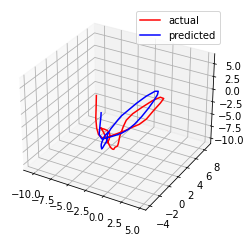

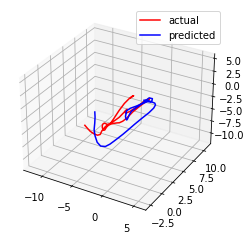

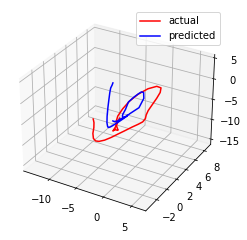

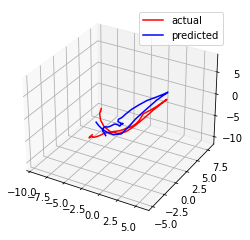

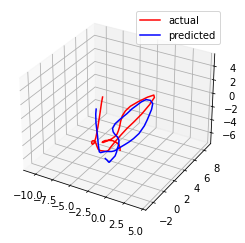

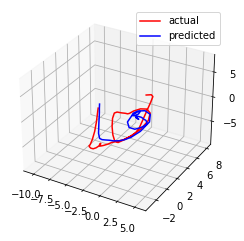

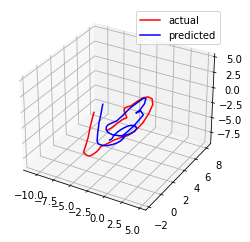

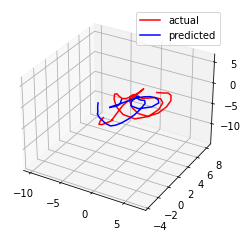

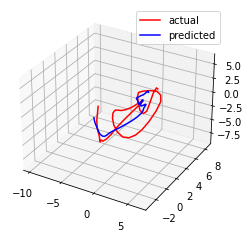

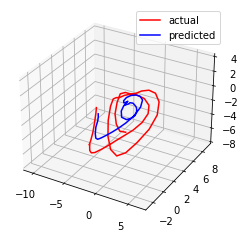

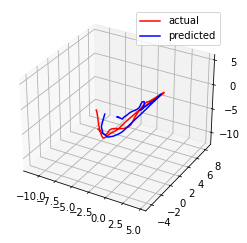

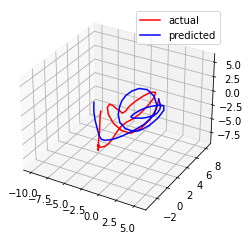

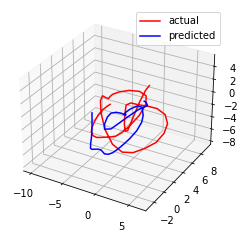

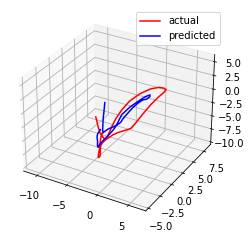

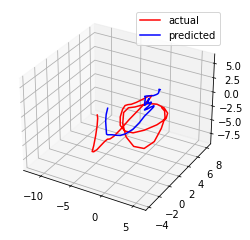

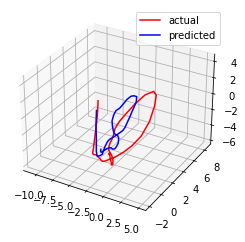

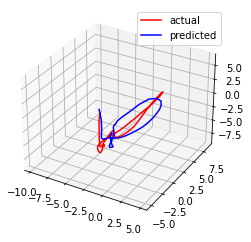

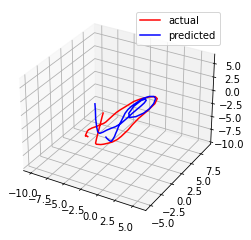

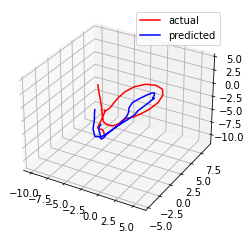

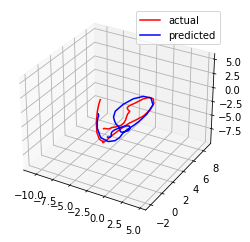

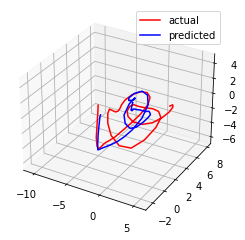

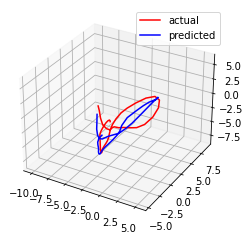

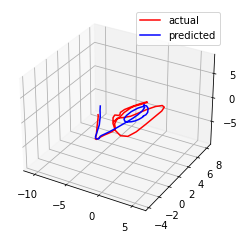

In [11]:
# unwrap y    
y_test_predicted = np.reshape(y_test_predicted, orig_y_test_shape)
y_test = np.reshape(y_test, orig_y_test_shape)

for i in range(len(y_test)):
    plt.figure(i)
    ax = plt.axes(projection='3d')
    train_coords = np.hsplit(y_test[i], 3)
    predicted_coords = np.hsplit(y_test_predicted[i], 3)
    ax.plot3D(train_coords[0].flatten(), train_coords[1].flatten(), train_coords[2].flatten(), 'red', label='actual')
    ax.plot3D(predicted_coords[0].flatten(), predicted_coords[1].flatten(), predicted_coords[2].flatten(), 'blue', label='predicted')
    plt.legend()
    plt.show()
    
results = {}
results['y_test'] = y_test
results['y_test_predicted'] = y_test_predicted
f = open('./Documents/decoder/data/M1_lstm_test.pkl', "wb")
pickle.dump(results, f)
f.close()